## Training on the WaDi Data Set

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.graphics.tsaplots import plot_acf
import math
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
# import torch
# from torch.utils.data import Dataset, DataLoader, TensorDataset
import keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2
import random
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from tabulate import tabulate

2026-01-14 17:50:59.318727: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
Train_df = pd.read_csv("/home/brandon/data/WADI_14days_new.csv")
#Train_df = Train.iloc[21600:].copy()
Train_df = Train_df.drop(columns = ['Row'])
Train_df['Date'] = pd.to_datetime(Train_df['Date'], format='mixed')
Train_df['Attack_Label'] = np.ones(Train_df.shape[0], dtype='float32')
Train_df

,Date,Time,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,1_LS_001_AL,1_LS_002_AL,...,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW,Attack_Label
0,2017-09-25,00:00.0,171.155,0.619473,11.5759,504.645,0.318319,0.001157,0,0,...,1,1,1,1,1,1,67.9651,1,0.68,1.0
1,2017-09-25,00:01.0,171.155,0.619473,11.5759,504.645,0.318319,0.001157,0,0,...,1,1,1,1,1,1,67.9651,1,0.68,1.0
2,2017-09-25,00:02.0,171.155,0.619473,11.5759,504.645,0.318319,0.001157,0,0,...,1,1,1,1,1,1,67.9651,1,0.68,1.0
3,2017-09-25,00:03.0,171.155,0.607477,11.5725,504.673,0.318438,0.001207,0,0,...,1,1,1,1,1,1,67.1948,1,0.68,1.0
4,2017-09-25,00:04.0,171.155,0.607477,11.5725,504.673,0.318438,0.001207,0,0,...,1,1,1,1,1,1,67.1948,1,0.68,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784566,2017-10-07,16:06.0,175.855,0.589478,11.8941,479.191,0.331571,0.001128,0,0,...,1,1,1,1,1,1,60.6305,1,0.25,1.0
784567,2017-10-07,16:07.0,175.855,0.589478,11.8941,479.191,0.331571,0.001128,0,0,...,1,1,1,1,1,1,60.6305,1,0.25,1.0
784568,2017-10-07,16:08.0,175.855,0.589478,11.8941,479.191,0.331571,0.001128,0,0,...,1,1,1,1,1,1,60.6305,1,0.25,1.0
784569,2017-10-07,16:09.0,175.896,0.613476,11.8913,479.224,0.331622,0.001173,0,0,...,1,1,1,1,1,1,60.4477,1,0.25,1.0


In [3]:
attack_df = pd.read_csv("/home/brandon/data/WADI_attackdataLABLE.csv", header = 1)
attack_df['Date'] = attack_df['Date ']
attack_df = attack_df[attack_df['Row '] <= 172801.0]
attack_df['Attack_Label'] = attack_df['Attack LABLE (1:No Attack, -1:Attack)']
attack_df = attack_df.drop(columns = ['Row ', 'Date ', 'Attack LABLE (1:No Attack, -1:Attack)'])
attack_df

,Time,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,1_LS_001_AL,1_LS_002_AL,1_LT_001_PV,...,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW,Date,Attack_Label
0,00:00.0,164.210,0.529486,11.9972,482.480,0.331167,0.001273,0.0,0.0,48.4820,...,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,10/9/17,1
1,00:01.0,164.210,0.529486,11.9972,482.480,0.331167,0.001273,0.0,0.0,48.4820,...,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,10/9/17,1
2,00:02.0,164.210,0.529486,11.9972,482.480,0.331167,0.001273,0.0,0.0,48.4820,...,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,10/9/17,1
3,00:03.0,164.210,0.529486,11.9972,482.480,0.331167,0.001273,0.0,0.0,48.4820,...,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,10/9/17,1
4,00:04.0,164.210,0.529486,11.9972,482.480,0.331167,0.001273,0.0,0.0,48.4820,...,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,10/9/17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172796,59:56.0,172.959,0.547483,11.9184,466.034,0.318217,0.001222,0.0,0.0,55.5587,...,1.0,1.0,1.0,1.0,1.0,59.3546,1.0,0.00,10/11/17,1
172797,59:57.0,172.959,0.547483,11.9184,466.034,0.318217,0.001222,0.0,0.0,55.5587,...,1.0,1.0,1.0,1.0,1.0,59.3546,1.0,0.00,10/11/17,1
172798,59:58.0,172.915,0.583479,11.9211,466.051,0.318317,0.001260,0.0,0.0,55.7260,...,1.0,1.0,1.0,1.0,1.0,58.8102,1.0,0.00,10/11/17,1
172799,59:59.0,172.915,0.583479,11.9211,466.051,0.318317,0.001260,0.0,0.0,55.7260,...,1.0,1.0,1.0,1.0,1.0,58.8102,1.0,0.00,10/11/17,1


In [6]:
Val_df = attack_df.loc[attack_df['Date'] == '10/9/17'].copy()

# 3. Create the Test DataFrame (Test_df) as the remainder
# Test_df = attack_df.loc[attack_df['Date'] != '10/9/17'].copy()

#Free up memory after splitting val and test sets
del attack_df

In [8]:
# Drop columns that are always NaN
# Identify columns that are always NaN in the training set
always_nan_cols = Train_df.columns[Train_df.isnull().all()].tolist()

print(f"\nNumber of columns that are always NaN in training data: {len(always_nan_cols)}")
print("Always-NaN columns:")
print(always_nan_cols)

Train_df = Train_df.drop(columns=always_nan_cols)
Val_df   = Val_df.drop(columns=always_nan_cols)
# Test_df  = Test_df.drop(columns=always_nan_cols)

print("\nAfter dropping always-NaN columns:")
print(f"Train shape: {Train_df.shape}")
print(f"Val shape:   {Val_df.shape}")
# print(f"Test shape:  {Test_df.shape}")


Number of columns that are always NaN in training data: 4
Always-NaN columns:
['2_LS_001_AL', '2_LS_002_AL', '2_P_001_STATUS', '2_P_002_STATUS']

After dropping always-NaN columns:
Train shape: (784571, 126)
Val shape:   (21600, 126)


NameError: name 'subset' is not defined

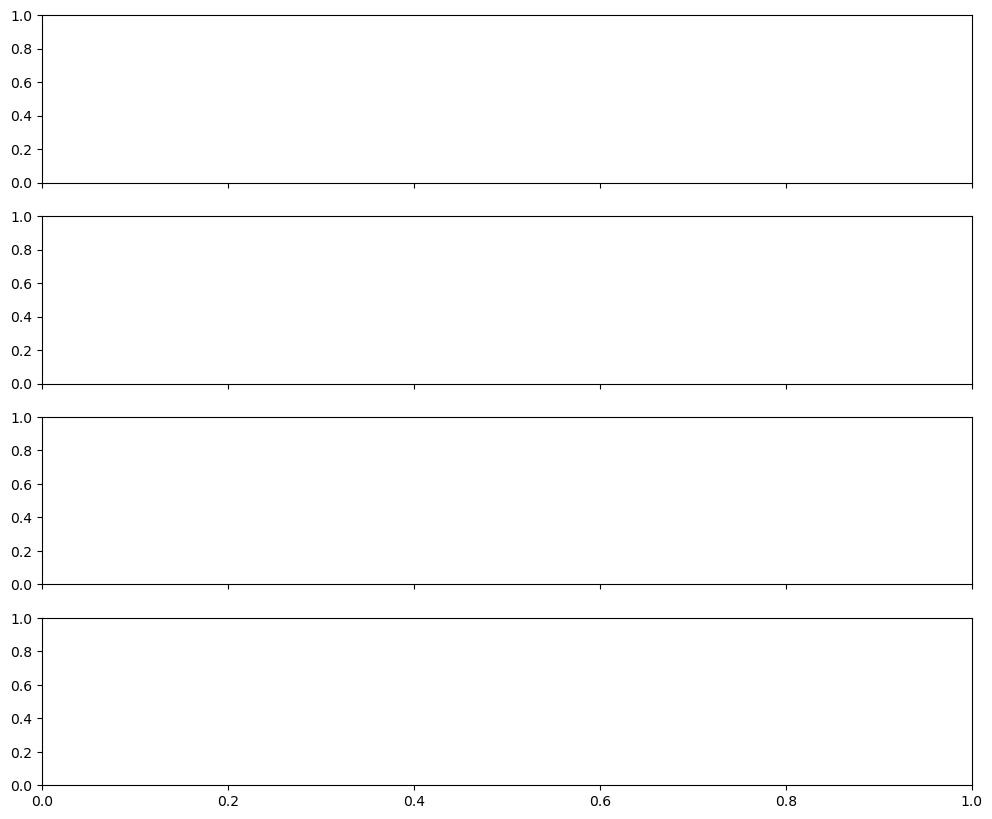

In [11]:
fig, axes = plt.subplots(nrows=len(always_nan_cols), ncols=1, figsize=(12, 10), sharex=True)

for i, col in enumerate(always_nan_cols):
    axes[i].plot(subset.index, subset[col], label=col, color='tab:blue')
    axes[i].set_ylabel('Value')
    axes[i].legend(loc='upper right')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Sensor Values Over Time (Gaps indicate NaNs)')
plt.xlabel('Time Index')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [12]:
# Use appropriate methods to handle missing values
# Use liner interpolation for missing values that spread out across the data
Train_df['1_AIT_002_PV'] = Train_df['1_AIT_002_PV'].interpolate(method='linear')
Train_df['1_AIT_004_PV'] = Train_df['1_AIT_004_PV'].interpolate(method='linear')
Train_df['2B_AIT_004_PV'] = Train_df['2B_AIT_004_PV'].interpolate(method='linear')
# Use forward fill for missing values that occur in blocks
Train_df['3_AIT_004_PV'] = Train_df['3_AIT_004_PV'].ffill()

In [13]:
# 4a. Find features using Train_df (as before)
features_original = [c for c in Train_df.columns if c not in ['Date', 'Time']]
constant_features = [col for col in features_original if Train_df[col].nunique() == 1]
features_final = [col for col in features_original if col not in constant_features]
print(f"Number of constant features removed: {len(constant_features)}")

scaler = MinMaxScaler()

# Transform the data using the NumPy arrays X_train, X_val, X_test
Train_scaled = scaler.fit_transform(Train_df[features_final])
Val_scaled = scaler.transform(Val_df[features_final])
# Test_scaled = scaler.transform(Test_df[features_final])

y_train = Train_df['Attack_Label'].values.astype('float32')
y_val = Val_df['Attack_Label'].values.astype('float32')
# y_test = Test_df['Attack_Label'].values.astype('float32')

Number of constant features removed: 31


In [14]:
def make_window_dataset(
    data,
    window_size,
    stride=1,
    batch_size=64
):
    ds = tf.data.Dataset.from_tensor_slices(data)
    ds = ds.window(
        size=window_size,
        shift=stride,
        drop_remainder=True
    )

    ds = ds.flat_map(lambda w: w.batch(window_size))

    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    # Autoencoder objective: X → X
    ds = ds.map(lambda x: (x, x))

    return ds

In [15]:
WINDOW_SIZE = 100
STRIDE = 1
BATCH_SIZE = 64
NUM_FEATURES = len(features_final)

train_ds = make_window_dataset(
    Train_scaled,
    window_size=WINDOW_SIZE,
    stride=10,
    batch_size=BATCH_SIZE
)

val_ds = make_window_dataset(
    Val_scaled,
    window_size=WINDOW_SIZE,
    stride=STRIDE,
    batch_size=BATCH_SIZE
)

y_val_ds = make_window_dataset(
    y_val,
    window_size=WINDOW_SIZE, 
    stride=STRIDE, 
    batch_size=BATCH_SIZE
)
# Extract label windows (resulting shape: [N_windows, 100, 1])
y_val_windows = np.concatenate([y for y, _ in y_val_ds], axis=0)

# Reduce window labels to a single binary label per window.
# Logic: If ANY point in the window is an attack (1), the window is labeled as attack.
# flattening along axis 1 (time) to check for any 1s
GRU_y_val_np = np.any(y_val_windows < 0, axis=1).astype(int).flatten()


I0000 00:00:1768438409.229705  637122 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22438 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1768438409.230161  637122 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22453 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:21:00.0, compute capability: 8.6
2026-01-14 17:53:31.619178: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### GRU

In [17]:
#GRU
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = '42'
tf.config.experimental.enable_op_determinism()

GRU_model = GRU_model = keras.Sequential([
    keras.Input(shape=(WINDOW_SIZE, NUM_FEATURES)),

    layers.GRU(units=64, return_sequences=False),
    layers.Dropout(0.2),
    layers.RepeatVector(WINDOW_SIZE),

    layers.GRU(units=64, return_sequences=True),
    layers.Dropout(0.2),
    layers.TimeDistributed(layers.Dense(NUM_FEATURES))
])

optimizer = keras.optimizers.Adam(learning_rate=1e-3)
GRU_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

GRU_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 64)             │        30,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 100, 64)        │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 100, 93)        │         6,045 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,533 (240.36 KB)

 Trainable params: 61,533 (240.36 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Train the GRU
GRU_history = GRU_model.fit(
    train_ds,
    validation_data = (val_ds),
    epochs = 30,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_loss', patience = 5, restore_best_weights = True)
    ]
)

Epoch 1/30


2026-01-14 17:55:22.323773: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700


   1226/Unknown 24s 17ms/step - loss: 0.0488 - mae: 0.1551

2026-01-14 17:55:43.789366: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/brandon/miniconda3/envs/ml/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1226/1226 ━━━━━━━━━━━━━━━━━━━━ 27s 19ms/step - loss: 0.0325 - mae: 0.1231 - val_loss: 0.0110 - val_mae: 0.0672
Epoch 2/30
   7/1226 ━━━━━━━━━━━━━━━━━━━━ 22s 18ms/step - loss: 0.0238 - mae: 0.0946

2026-01-14 17:55:46.985422: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1226/1226 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - loss: 0.0174 - mae: 0.0834 - val_loss: 0.0098 - val_mae: 0.0620
Epoch 3/30
   7/1226 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.0206 - mae: 0.0864

2026-01-14 17:56:10.471584: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2026-01-14 17:56:10.471620: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14663523764116634900


1226/1226 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0146 - mae: 0.0744 - val_loss: 0.0087 - val_mae: 0.0598
Epoch 4/30
   7/1226 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.0177 - mae: 0.0814

2026-01-14 17:56:34.051349: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14663523764116634900


1226/1226 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0140 - mae: 0.0723 - val_loss: 0.0082 - val_mae: 0.0557
Epoch 5/30
   7/1226 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.0161 - mae: 0.0756

2026-01-14 17:56:57.649747: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1226/1226 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0127 - mae: 0.0680 - val_loss: 0.0072 - val_mae: 0.0505
Epoch 6/30
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0121 - mae: 0.0657 - val_loss: 0.0064 - val_mae: 0.0456
Epoch 7/30
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - loss: 0.0113 - mae: 0.0632 - val_loss: 0.0065 - val_mae: 0.0471
Epoch 8/30
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0111 - mae: 0.0628 - val_loss: 0.0063 - val_mae: 0.0472
Epoch 9/30
   7/1226 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - loss: 0.0135 - mae: 0.0679

2026-01-14 17:58:31.899902: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1226/1226 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0106 - mae: 0.0609 - val_loss: 0.0066 - val_mae: 0.0490
Epoch 10/30
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0103 - mae: 0.0600 - val_loss: 0.0061 - val_mae: 0.0459
Epoch 11/30
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - loss: 0.0100 - mae: 0.0591 - val_loss: 0.0061 - val_mae: 0.0455
Epoch 12/30
   8/1226 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 0.0120 - mae: 0.0621

2026-01-14 17:59:42.680837: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14663523764116634900


1226/1226 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0098 - mae: 0.0581 - val_loss: 0.0062 - val_mae: 0.0451
Epoch 13/30
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0096 - mae: 0.0576 - val_loss: 0.0063 - val_mae: 0.0475
Epoch 14/30
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0096 - mae: 0.0574 - val_loss: 0.0056 - val_mae: 0.0420
Epoch 15/30
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0094 - mae: 0.0566 - val_loss: 0.0055 - val_mae: 0.0425
Epoch 16/30
   7/1226 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.0112 - mae: 0.0606

2026-01-14 18:01:16.957754: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14663523764116634900


1226/1226 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0092 - mae: 0.0564 - val_loss: 0.0052 - val_mae: 0.0400
Epoch 17/30
   7/1226 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.0109 - mae: 0.0585

2026-01-14 18:01:40.672665: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1226/1226 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0092 - mae: 0.0560 - val_loss: 0.0057 - val_mae: 0.0432
Epoch 18/30
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0090 - mae: 0.0555 - val_loss: 0.0055 - val_mae: 0.0412
Epoch 19/30
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0090 - mae: 0.0554 - val_loss: 0.0052 - val_mae: 0.0401
Epoch 20/30
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0089 - mae: 0.0550 - val_loss: 0.0052 - val_mae: 0.0397
Epoch 21/30
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0087 - mae: 0.0542 - val_loss: 0.0053 - val_mae: 0.0399
Epoch 22/30
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0087 - mae: 0.0542 - val_loss: 0.0050 - val_mae: 0.0388
Epoch 23/30
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0084 - mae: 0.0533 - val_loss: 0.0048 - val_mae: 0.0382
Epoch 24/30
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0084 - mae: 0.0533 - val_loss: 0.0050 - val_mae: 0.0386
Epoch 25/30
   7/1226 ━━━━━━

2026-01-14 18:04:49.444657: I tensorflow/core/framework/local_rendezvous.cc:426] Local rendezvous recv item cancelled. Key hash: 14663523764116634900


1226/1226 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0084 - mae: 0.0535 - val_loss: 0.0051 - val_mae: 0.0388
Epoch 26/30
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0082 - mae: 0.0528 - val_loss: 0.0048 - val_mae: 0.0377
Epoch 27/30
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0164 - mae: 0.0722 - val_loss: 0.0125 - val_mae: 0.0669
Epoch 28/30
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0205 - mae: 0.0847 - val_loss: 0.0101 - val_mae: 0.0592
Epoch 29/30
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0181 - mae: 0.0790 - val_loss: 0.0090 - val_mae: 0.0551
Epoch 30/30
1226/1226 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 0.0176 - mae: 0.0775 - val_loss: 0.0087 - val_mae: 0.0550


In [19]:
# --- 1. Get Predictions and Ground Truth from the Dataset ---
print("Generating predictions...")
# .predict() works directly on the dataset
GRU_X_val_pred = GRU_model.predict(val_ds) 

# Extract the "Ground Truth" input windows from the dataset
# We iterate over the dataset to concatenate all batches into one numpy array
X_val_np = np.concatenate([x for x, _ in val_ds], axis=0)

GRU_reconstruction_error = np.mean(np.square(GRU_X_val_pred - X_val_np), axis=(1, 2))

# --- 4. Evaluation ---
GRU_BEST_THRESHOLD = 0.05

GRU_y_pred_labels = (GRU_reconstruction_error > GRU_BEST_THRESHOLD).astype(int)

GRU_prec, GRU_rec, GRU_f1, _ = precision_recall_fscore_support(
    GRU_y_val_np, GRU_y_pred_labels, average='binary', zero_division=0
)

# Calculate metrics
GRU_mean_error = np.mean(GRU_reconstruction_error)
GRU_std_error = np.std(GRU_reconstruction_error)
GRU_training_error = GRU_history.history['loss'][-1]
GRU_validation_error = GRU_history.history['val_loss'][-1]

print("-" * 30)
print(f"GRU Metrics: Mean Error = {GRU_mean_error:.4f}, Std Dev = {GRU_std_error:.4f}")
print(f"Training Loss = {GRU_training_error:.4f}, Validation Loss = {GRU_validation_error:.4f}")
print("-" * 30)
print(f"Precision: {GRU_prec:.3f}")
print(f"Recall:    {GRU_rec:.3f}")
print(f"F1 Score:  {GRU_f1:.3f}")
print("-" * 30)

Generating predictions...
336/336 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


/home/brandon/miniconda3/envs/ml/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


------------------------------
GRU Metrics: Mean Error = 0.0048, Std Dev = 0.0031
Training Loss = 0.0176, Validation Loss = 0.0087
------------------------------
Precision: 0.000
Recall:    0.000
F1 Score:  0.000
------------------------------


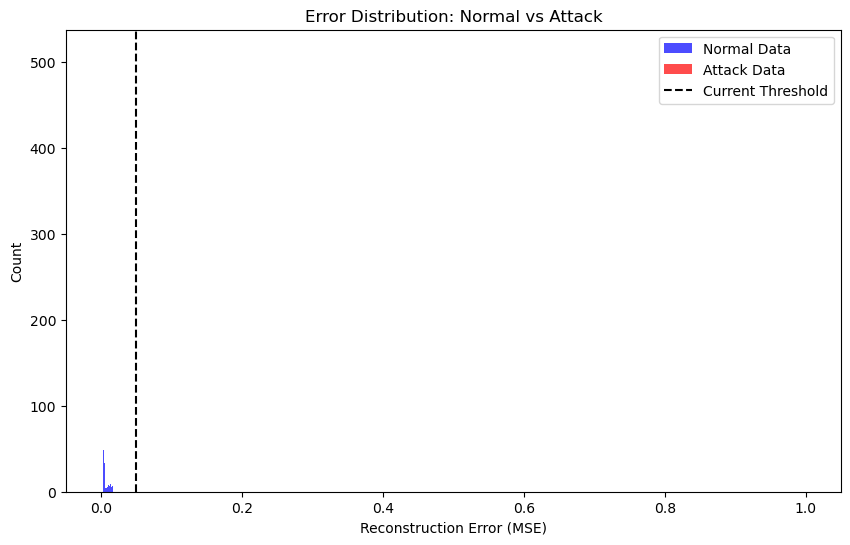

Normal Error | Mean: 0.0047 | Max: 0.0171


/home/brandon/miniconda3/envs/ml/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/brandon/miniconda3/envs/ml/lib/python3.10/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation minimum which has no identity

In [20]:
normal_errors = GRU_reconstruction_error[GRU_y_val_np == 1]
attack_errors = GRU_reconstruction_error[GRU_y_val_np == -1]

# 2. Plot Histogram
plt.figure(figsize=(10, 6))
plt.hist(normal_errors, bins=50, alpha=0.7, label='Normal Data', color='blue')
plt.hist(attack_errors, bins=50, alpha=0.7, label='Attack Data', color='red')

# 3. Add your current threshold line
plt.axvline(x=GRU_BEST_THRESHOLD, color='k', linestyle='--', label='Current Threshold')

plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Count')
plt.title('Error Distribution: Normal vs Attack')
plt.legend()
plt.show()

# 4. Print stats to help you pick a number
print(f"Normal Error | Mean: {np.mean(normal_errors):.4f} | Max: {np.max(normal_errors):.4f}")
print(f"Attack Error | Mean: {np.mean(attack_errors):.4f} | Min: {np.min(attack_errors):.4f}")
print(f"Seperation Gap: {np.min(attack_errors) - np.max(normal_errors):.4f}")

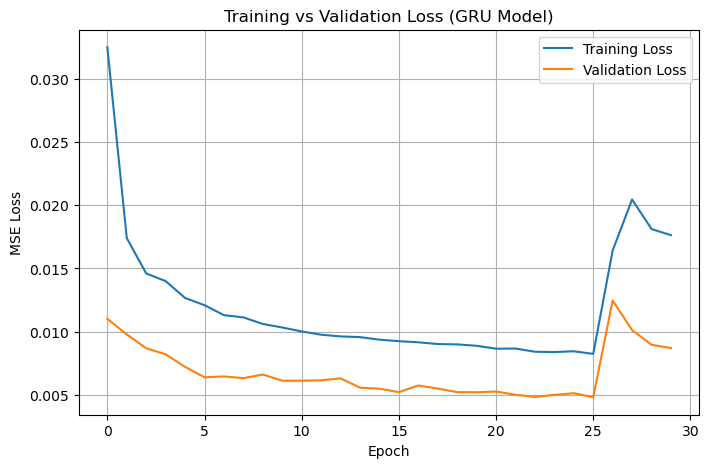

In [21]:
loss_key = 'loss'
val_loss_key = 'val_loss'

plt.figure(figsize=(8,5))
plt.plot(GRU_history.history[loss_key], label='Training Loss')
plt.plot(GRU_history.history[val_loss_key], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss (GRU Model)")
plt.legend()
plt.grid(True)
plt.show()

### LSTM

In [30]:
# LSTM
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = '42'
tf.config.experimental.enable_op_determinism()

# Create the model with encoder and decoder
LSTM_model = keras.Sequential([
    keras.Input(shape=(WINDOW_SIZE, NUM_FEATURES)),
    # Encoder
    layers.LSTM(units = 64,return_sequences = False),
    layers.RepeatVector(WINDOW_SIZE),

    #Decoder
    layers.LSTM(units = 64, return_sequences=True),
    layers.TimeDistributed(layers.Dense(NUM_FEATURES, activation = 'linear'))
])

optimizer = keras.optimizers.Adam(learning_rate=1e-3)
LSTM_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
LSTM_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        40,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 100, 93)        │         6,045 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,517 (310.61 KB)

 Trainable params: 79,517 (310.61 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
LSTM_history = LSTM_model.fit(
    train_ds,
    validation_data=(val_ds),
    epochs=30,
    batch_size=64,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/30


2026-01-13 20:28:17.745366: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700


   1191/Unknown 23s 16ms/step - loss: 0.0445 - mae: 0.1350

2026-01-13 20:28:37.654289: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/brandon/miniconda3/envs/ml/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1192/1192 ━━━━━━━━━━━━━━━━━━━━ 26s 19ms/step - loss: 0.0322 - mae: 0.1119 - val_loss: 0.0201 - val_mae: 0.0869
Epoch 2/30
   8/1192 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.0226 - mae: 0.0851

2026-01-13 20:28:40.866304: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1192/1192 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 0.0184 - mae: 0.0783 - val_loss: 0.0138 - val_mae: 0.0687
Epoch 3/30
   7/1192 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.0185 - mae: 0.0721

2026-01-13 20:29:03.136115: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1192/1192 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 0.0144 - mae: 0.0682 - val_loss: 0.0101 - val_mae: 0.0584
Epoch 4/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 0.0124 - mae: 0.0622 - val_loss: 0.0087 - val_mae: 0.0555
Epoch 5/30
   8/1192 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.0131 - mae: 0.0633

2026-01-13 20:29:47.840011: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1192/1192 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 0.0111 - mae: 0.0584 - val_loss: 0.0077 - val_mae: 0.0535
Epoch 6/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 22s 19ms/step - loss: 0.0099 - mae: 0.0551 - val_loss: 0.0076 - val_mae: 0.0511
Epoch 7/30
1192/1192 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0089 - mae: 0.0526

KeyboardInterrupt: 